In [26]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.exceptions import ConvergenceWarning

plt.style.use('ggplot')
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning) 

start = time.perf_counter()

In [27]:
df = pd.read_csv('earl694412-infinite-matchhistory.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Date                         1084 non-null   object 
 1   SeasonNumber                 1084 non-null   int64  
 2   SeasonVersion                1084 non-null   int64  
 3   Player                       1084 non-null   object 
 4   MatchId                      1084 non-null   object 
 5   Map                          1084 non-null   object 
 6   Category                     1084 non-null   object 
 7   Playlist                     1084 non-null   object 
 8   Input                        1084 non-null   object 
 9   Queue                        1084 non-null   object 
 10  PreCsr                       1084 non-null   int64  
 11  PostCsr                      1084 non-null   int64  
 12  WinningTeam                  13 non-null     object 
 13  WinningTeamCSR    

In [28]:
# General Fixes+Additions
df['Date'] = pd.to_datetime(df['Date'])
df['LengthMinutes'] = df['LengthSeconds'] / 60
df.rename(columns={'TotalKills': 'Kills'}, inplace=True)
df['KillsBody'] = df['Kills'] - df['KillsGrenade'] - df['KillsHeadshot'] - df['KillsMelee'] - df['KillsPower']
# Ratios
df['DamageRatio'] = df['DamageDone'].replace(0, 1) / df['DamageTaken'].replace(0, 1)
df['Damage/Life'] = df['DamageDone'] / df['Deaths'].replace(0,1)
df['Damage/Kill'] = df['DamageDone'] / df['Kills']
df['Damage/KA'] = df['DamageDone'] / (df['Kills'] + df['Assists'])
# Per 10 Min
df['Kills/10Min'] = (df['Kills'] / df['LengthMinutes']) * 10
df['Deaths/10Min'] = (df['Deaths'] / df['LengthMinutes']) * 10
df['Assists/10Min'] = (df['Assists'] / df['LengthMinutes']) * 10
df['Dmg/10Min'] = (df['DamageDone'] / df['LengthMinutes']) * 10
df['DmgT/10Min'] = (df['DamageTaken'] / df['LengthMinutes']) * 10
df['Shots/10Min'] = (df['ShotsFired'] / df['LengthMinutes']) * 10
# Excess
df['ExcessKills'] = df['Kills'] - df['ExpectedKills']
df['ExcessDeaths'] = df['ExpectedDeaths'] - df['Deaths']
# Kill Type
df['BodyPct'] = df['KillsBody'] / df['Kills'] *100
df['MeleePct'] = df['KillsMelee'] / df['Kills'] * 100
df['HSPct'] = df['KillsHeadshot'] / df['Kills'] * 100
df['GrenadePct'] = df['KillsGrenade'] / df['Kills'] * 100
df['PowerPct'] = df['KillsPower'] / df['Kills'] * 100



df = df.drop(['Player', 'MatchId', 'Input', 'Queue', 'Mmr', 'PreCsr', 'PostCsr', 'ShotsFired', 'AssistsEmp',
              'ShotsMissed', 'ShotsLanded', 'Betrayals', 'Suicides', 'WasAtStart', 'WasAtEnd', 'AssistsDriver',
              'Perfects', 'WasInProgressJoin', 'VehicleDestroys', 'VehicleHijacks', 'AssistsCallout',
              'LengthSeconds', 'Rank', 'SeasonNumber', 'SeasonVersion', 'Map', 'WinningTeamScore',
            'WinningTeam','WinningTeamCSR', 'WinningTeamMMR', 'WinningTeamFinalScore', 'WinningTeamWinPercentChance',
            'LosingTeam', 'LosingTeamCSR', 'LosingTeamMMR', 'LosingTeamScore' ,'LosingTeamFinalScore',
            'LosingTeamWinPercentChance'],axis=1)
df = df.drop(['KillsBody','KillsMelee', 'KillsGrenade', 'KillsHeadshot', 'KillsPower'], axis=1)
# df = df.drop(['Kills','Deaths', 'Assists', 'DamageDone', 'DamageTaken'], axis=1)
dfR = df[df['Playlist'] == 'Ranked Arena']
dfRR = dfR[dfR['Date']> '2023-01-01']
dfRR = dfRR[dfRR['Outcome'] != 'Draw']
dfRR = dfRR[dfRR['Outcome'] != 'Left']
dfRR['Outcome'] = dfRR['Outcome'].map({'Win': 1, 'Loss': 0})
dfRR = dfRR.drop(['Date', 'Category', 'Playlist'], axis=1)
dfRR = dfRR.dropna()
dfRR.describe()

,Outcome,Accuracy,DamageDone,DamageTaken,KD,KDA,Kills,Deaths,Assists,MaxSpree,...,Dmg/10Min,DmgT/10Min,Shots/10Min,ExcessKills,ExcessDeaths,BodyPct,MeleePct,HSPct,GrenadePct,PowerPct
count,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,...,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000,804.000000
mean,0.553483,52.874428,5317.914179,4568.631841,1.262289,4.489826,14.628109,13.022388,8.657960,3.947761,...,4965.556185,4247.710398,221.739333,-0.023632,1.664179,28.250816,9.621069,53.252755,7.003828,1.871533
std,0.497441,5.523445,1835.738165,1552.413793,0.735203,5.769308,6.312316,5.148552,4.251575,1.661147,...,840.796531,688.260327,41.328486,4.098499,2.568932,14.017734,8.472335,14.896599,7.875652,5.353247
min,0.000000,20.450000,619.000000,0.000000,0.230000,-10.000000,1.000000,0.000000,0.000000,1.000000,...,1209.771987,0.000000,67.741935,-11.000000,-7.000000,-12.500000,0.000000,11.111111,0.000000,0.000000
25%,0.000000,49.390000,3928.000000,3497.750000,0.830000,0.660000,10.000000,10.000000,6.000000,3.000000,...,4436.139976,3869.561673,196.343136,-3.000000,0.000000,20.000000,0.000000,43.750000,0.000000,0.000000
50%,1.000000,52.895000,5100.000000,4405.500000,1.120000,4.330000,14.000000,13.000000,8.000000,4.000000,...,4975.701860,4323.402673,221.598940,0.000000,2.000000,27.777778,8.695652,53.333333,5.718954,0.000000
75%,1.000000,56.347500,6537.000000,5602.500000,1.450000,7.745000,18.000000,16.000000,11.000000,5.000000,...,5501.626407,4729.772872,245.436978,2.000000,3.000000,37.500000,14.285714,63.636364,11.111111,0.000000
max,1.000000,80.560000,12673.000000,9962.000000,10.000000,31.000000,40.000000,32.000000,28.000000,15.000000,...,7302.793296,6345.913819,475.662651,17.000000,10.000000,77.777778,61.538462,100.000000,50.000000,40.000000


In [29]:
dfRR.describe().transpose()
# dfRR[dfRR['Damage/Life']==np.nan]

,count,mean,std,min,25%,50%,75%,max
Outcome,804.0,0.553483,0.497441,0.000000,0.000000,1.000000,1.000000,1.000000
Accuracy,804.0,52.874428,5.523445,20.450000,49.390000,52.895000,56.347500,80.560000
DamageDone,804.0,5317.914179,1835.738165,619.000000,3928.000000,5100.000000,6537.000000,12673.000000
DamageTaken,804.0,4568.631841,1552.413793,0.000000,3497.750000,4405.500000,5602.500000,9962.000000
KD,804.0,1.262289,0.735203,0.230000,0.830000,1.120000,1.450000,10.000000
KDA,804.0,4.489826,5.769308,-10.000000,0.660000,4.330000,7.745000,31.000000
Kills,804.0,14.628109,6.312316,1.000000,10.000000,14.000000,18.000000,40.000000
Deaths,804.0,13.022388,5.148552,0.000000,10.000000,13.000000,16.000000,32.000000
Assists,804.0,8.657960,4.251575,0.000000,6.000000,8.000000,11.000000,28.000000
MaxSpree,804.0,3.947761,1.661147,1.000000,3.000000,4.000000,5.000000,15.000000


In [30]:
corr_mtrx = dfRR.corr().abs()
print(corr_mtrx['Outcome'].sort_values(ascending=False))

Outcome           1.000000
Deaths/10Min      0.448042
DmgT/10Min        0.370961
Damage/Life       0.331484
KD                0.326423
Deaths            0.325768
KDA               0.294568
Damage/KA         0.288187
ExcessDeaths      0.270371
DamageTaken       0.253385
ExpectedDeaths    0.209988
Damage/Kill       0.191685
Assists/10Min     0.166317
Kills/10Min       0.153936
LengthMinutes     0.135481
DamageDone        0.091512
Accuracy          0.089448
MaxSpree          0.080246
Assists           0.052529
HSPct             0.038754
ExpectedKills     0.037627
Score             0.036488
DamageRatio       0.035995
BodyPct           0.033692
Dmg/10Min         0.030800
PowerPct          0.030628
ExcessKills       0.028413
Medals            0.016745
GrenadePct        0.012717
Kills             0.008134
MeleePct          0.004865
Shots/10Min       0.000689
Name: Outcome, dtype: float64


In [31]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [32]:
# Define features (X) and target variable (y)
X = dfRR.drop('Outcome', axis=1) 
X = round(X,20)
y = dfRR['Outcome'] 

print(f'X Shape: {X.shape}')
print(f'Y Shape: {y.shape}')

X Shape: (804, 31)
Y Shape: (804,)


In [33]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=27)
print(f'X Train Shape: {X_train.shape}')
print(f'X Test Shape: {X_test.shape}')
# print(X_train.columns)
print(f'Y Train Mean: {round(y_train.mean(),3)}')
print(f'Y Test Mean: {round(y_test.mean(),3)}')

X Train Shape: (643, 31)
X Test Shape: (161, 31)
Y Train Mean: 0.555
Y Test Mean: 0.547


In [34]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler


# Define the column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Accuracy', 'ExpectedKills', 'ExpectedDeaths', 'KD', 
                                    'KDA', 'MaxSpree', 'Deaths', 'Assists', 'Kills', 'DamageDone', 
                                    'DamageTaken', 'Score', 'Medals', 'LengthMinutes', 
                                    'DamageRatio', 'Damage/Kill', 'Damage/KA', 'Damage/Life',
                                    'Kills/10Min', 'Deaths/10Min', 'Assists/10Min', 'Dmg/10Min',
                                    'DmgT/10Min', 'Shots/10Min', 'ExcessKills', 'ExcessDeaths',
                                    'BodyPct', 'MeleePct', 'HSPct', 'GrenadePct', 'PowerPct'])])

# Create the pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Fit and transform the data
X_train_pp = pipeline.fit_transform(X_train)
X_test_pp = pipeline.transform(X_test)

from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train_pp, X_val_pp, y_train, y_val = train_test_split(X_train_pp, y_train, test_size=0.2, random_state=2)

# X_train_preprocessed.to_csv('X_train_preprocessed.csv')
# X_test_preprocessed.to_csv('X_test_preprocessed.csv')
print(f'X Train Processed Shape: {X_train_pp.shape}')
print(f'X Val Processed Shape: {X_val_pp.shape}')
print(f'X Test Processed Shape: {X_test_pp.shape}')
print(f'Y Train Shape: {y_train.shape}')
print(f'Y Val Shape: {y_val.shape}')
print(f'Y Test Shape: {y_test.shape}')

X Train Processed Shape: (514, 31)
X Val Processed Shape: (129, 31)
X Test Processed Shape: (161, 31)
Y Train Shape: (514,)
Y Val Shape: (129,)
Y Test Shape: (161,)


In [25]:
print(f"Y Train Mean: {round(y_train.mean(),3)}")
print(f"Y Val Mean: {round(y_val.mean(),3)}")
print(f"Y Test Mean: {round(y_test.mean(),3)}")

Y Train Mean: 0.549
Y Val Mean: 0.55
Y Test Mean: 0.571


In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'activation': ['logistic', 'tanh', 'relu', 'identity'],
    'solver': ['sgd', 'adam', 'lbfgs'],
    'alpha': [0.001, 0.01, 0.1, 1],
    'learning_rate': ['constant', 'adaptive']
}

# Perform grid search
grid_search = GridSearchCV(MLPClassifier(random_state=27), param_grid, cv=5)
grid_search.fit(X_train_pp, y_train)

# Get the best parameters and model
best_mlp = grid_search.best_estimator_
best_mlp_stats = {
    'Training Accuracy': best_mlp.score(X_train_pp, y_train),
    'Validation Accuracy': best_mlp.score(X_val_pp, y_val),
    'Test Accuracy': best_mlp.score(X_test_pp, y_test)
}
print(best_mlp_stats)
print(best_mlp)

{'Training Accuracy': 0.8365758754863813, 'Validation Accuracy': 0.813953488372093, 'Test Accuracy': 0.8074534161490683}
MLPClassifier(activation='identity', alpha=1, random_state=27, solver='lbfgs')


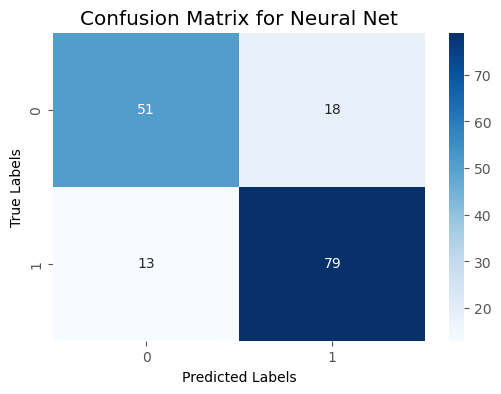

The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.


<Axes: >

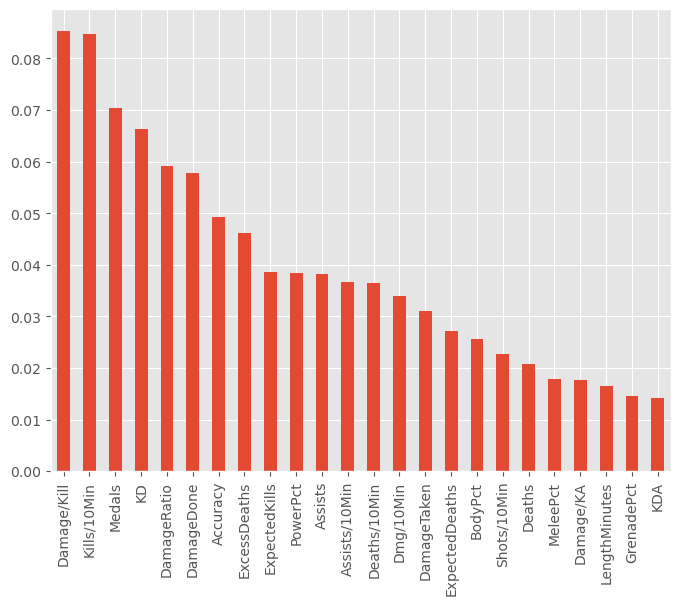

In [22]:
from sklearn.metrics import confusion_matrix
# Generate confusion matrix for the Neural Net
conf_matrix = confusion_matrix(y_test, best_mlp.predict(X_test_pp))
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Neural Net')
plt.show()

print("The confusion matrix shows the true positive, false negative, false positive, and true negative values, helping to evaluate the performance of a classification model.")
feat_importances_mlpc = pd.DataFrame(best_mlp.coefs_[0].flatten()[:31], index=X_train.columns, columns=["Importance"])
feat_importances_mlpc = feat_importances_mlpc.abs().sum(axis=1)
feat_importances_mlpc = feat_importances_mlpc / feat_importances_mlpc.sum()
feat_importances_mlpc = feat_importances_mlpc.sort_values(ascending=False)[:24]
feat_importances_mlpc.plot(kind='bar', figsize=(8,6))

## Torch Simple Neural Net

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

y_train_array = y_train.values
y_val_array = y_val.values

# Then create tensors from the NumPy arrays
X_train_pp_tensor = torch.tensor(X_train_pp, dtype=torch.float)
y_train_tensor = torch.tensor(y_train_array, dtype=torch.long)
X_val_pp_tensor = torch.tensor(X_val_pp, dtype=torch.float)
y_val_tensor = torch.tensor(y_val_array, dtype=torch.long)

In [36]:
class SimpleNeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Instantiate the model
input_size = 31  # Replace with the actual input size
hidden_size = 15 # Replace with the desired hidden layer size
output_size = 2  # Replace with the actual output size
model = SimpleNeuralNet(input_size, hidden_size, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005)

val_losses = []
losses = []
val_accuracies = []
accuracies = []

prev_loss = float('inf')
prev_val_loss = float('inf')  # Initialize with a large value

for epoch in tqdm(range(50000)):
    optimizer.zero_grad()
    outputs = model(X_train_pp_tensor)
    loss = criterion(outputs, y_train_tensor)
    prev_loss = loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    
    # Calculate training accuracy
    with torch.no_grad():
        predicted = torch.argmax(outputs, 1)
        correct = (predicted == y_train_tensor).sum().item()
        accuracy = correct / y_train_tensor.size(0)
        accuracies.append(accuracy)
        
        # Calculate validation loss and accuracy
        val_outputs = model(X_val_pp_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_losses.append(val_loss.item())
        val_predicted = torch.argmax(val_outputs, 1)
        val_correct = (val_predicted == y_val_tensor).sum().item()
        val_accuracy = val_correct / y_val_tensor.size(0)
        val_accuracies.append(val_accuracy)
        
        prev_val_loss = val_loss


  0%|          | 0/50000 [00:00<?, ?it/s]

100%|██████████| 50000/50000 [00:55<00:00, 897.44it/s] 


In [ ]:
# from torch.utils.data import TensorDataset, DataLoader

# # Convert training and validation data to TensorDataset
# train_dataset = TensorDataset(torch.tensor(X_train_pp, dtype=torch.float),
#                               torch.tensor(y_train_array, dtype=torch.long))
# val_dataset = TensorDataset(torch.tensor(X_val_pp, dtype=torch.float),
#                             torch.tensor(y_val_array, dtype=torch.long))

# # Define batch size
# batch_size = 32  # Replace with your desired batch size

# # Create DataLoader objects for batching
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size)

# # Inside your training loop
# for epoch in tqdm(range(10000)):
#     for batch in train_loader:
#         optimizer.zero_grad()
#         inputs, targets = batch
#         outputs = model(inputs)
#         loss = criterion(outputs, targets)
#         loss.backward()
#         optimizer.step()
#         losses.append(loss.item())
    
#     # Calculate training accuracy
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         train_correct = 0
#         total_train = 0
#         for batch in train_loader:
#             inputs, targets = batch
#             outputs = model(inputs)
#             _, predicted = torch.max(outputs.data, 1)
#             total_train += targets.size(0)
#             train_correct += (predicted == targets).sum().item()
#         train_accuracy = train_correct / total_train
#         accuracies.append(train_accuracy)

#     # Calculate validation loss and accuracy
#     model.eval()  # Set model to evaluation mode
#     with torch.no_grad():
#         val_loss = 0
#         val_correct = 0
#         total_val = 0
#         for batch in val_loader:
#             inputs, targets = batch
#             outputs = model(inputs)
#             loss = criterion(outputs, targets)
#             val_loss += loss.item()
#             _, predicted = torch.max(outputs.data, 1)
#             total_val += targets.size(0)
#             val_correct += (predicted == targets).sum().item()
#         val_accuracy = val_correct / total_val
#         val_losses.append(val_loss / len(val_loader))
#         val_accuracies.append(val_accuracy)


In [37]:
# Assuming X_test_preprocessed and y_test are your test data
X_test_pp_tensor = torch.tensor(X_test_pp, dtype=torch.float)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Evaluate the model on the test set
with torch.no_grad():
    test_outputs = model(X_test_pp_tensor)
    test_loss = criterion(test_outputs, y_test_tensor)
    test_predicted = torch.argmax(test_outputs, 1)
    test_correct = (test_predicted == y_test_tensor).sum().item()
    test_accuracy = test_correct / y_test_tensor.size(0)

print(f'Epochs: {len(losses)}')
print(f'Training Loss: {loss}')
print(f'Training Accuracy: {accuracy}')
print(f'Validation Loss: {val_losses[-1]}')
print(f'Validation Accuracy: {val_accuracies[-1]}')
print(f'Test Loss: {test_loss.item()}')
print(f'Test Accuracy: {test_accuracy}')


Epochs: 50000
Training Loss: 0.45097702741622925
Training Accuracy: 0.8754863813229572
Validation Loss: 0.5201283097267151
Validation Accuracy: 0.7906976744186046
Test Loss: 0.4875889718532562
Test Accuracy: 0.8012422360248447


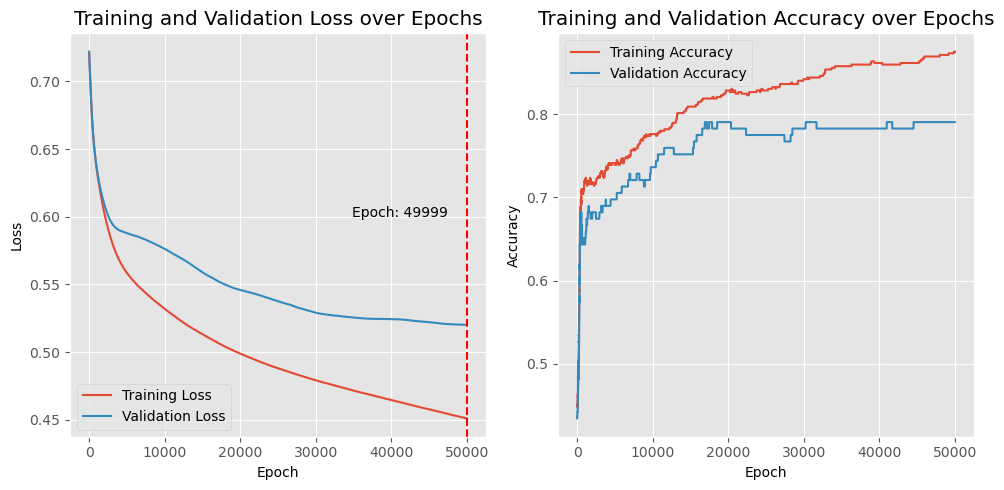

In [38]:
import matplotlib.pyplot as plt
epochs = range(1, len(losses) + 1)

# Plotting training and validation losses
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
# Plotting a line on the x-axis where Validation Loss is at its lowest
min_val_loss_epoch = val_losses.index(min(val_losses)) + 1
tenPCT = len(val_losses) * 0.05

plt.axvline(x=min_val_loss_epoch, color='r', linestyle='--')
plt.text(min_val_loss_epoch - tenPCT, 0.6, f'Epoch: {min_val_loss_epoch}', ha='right')

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()
